# Détection du niveau de remplissage des conteneurs à déchets

Pour entrainer le modèle, j'ai choisi deux classes :</br>
    - **full** (**pleine**) pour indiquer que la poubelle est totalement remplie.</br>
    - **empty** ou plus correctement "not full" (**pas pleine**) pour indiquer que la poubelle peut encore accueillir des déchets.</br>

In [37]:
import os
import matplotlib.pyplot as plt
from PIL import Image
import math
import numpy as np
import pandas as pd
import os


In [38]:
dir_example = "data"

classes = os.listdir(dir_example)
print(classes)

['empty', 'full']


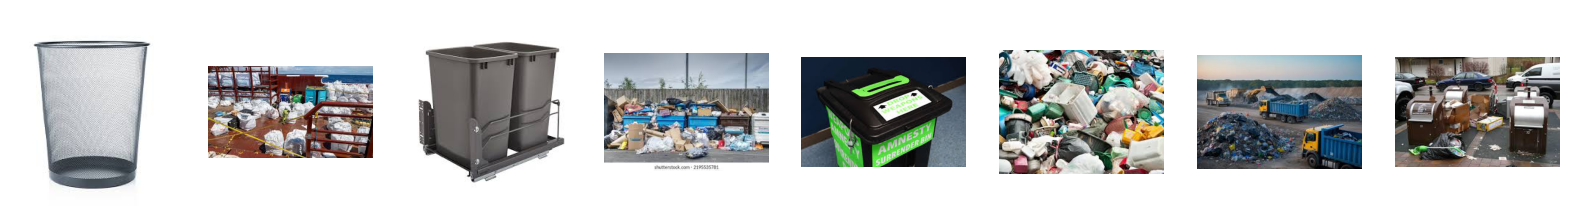

In [39]:
# Visualisation de quelques donnees
dir_with_examples = "google_images/exemples"
files_per_row = 8
files_in_dir = os.listdir(dir_with_examples)
number_of_cols = files_per_row
number_of_rows = int(len(files_in_dir) / number_of_cols)

# Generate the subplots
fig, axs = plt.subplots(number_of_rows, number_of_cols)
fig.set_size_inches(20, 15, forward=True)

# Map each file to subplot
try:
  for i in range(0, len(files_in_dir)):
    file_name = files_in_dir[i]
    image = Image.open(f'{dir_with_examples}/{file_name}')
    row = math.floor(i / files_per_row)
    col = i % files_per_row
    axs[col].imshow(image)
    axs[col].axis('off')
except:
  pass
# Show the plot
plt.show()

In [40]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from keras.layers import Conv2D, Flatten, MaxPooling2D, Dense, Dropout, SpatialDropout2D, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array

In [41]:
# chargement des emplacements des données
full_data_path = 'data/full'
empty_data_path = 'data/empty'
full_data_files = [os.path.join(full_data_path, file) for file in os.listdir(full_data_path) if os.path.isfile(os.path.join(full_data_path, file))]
empty_data_files = [os.path.join(empty_data_path, file) for file in os.listdir(empty_data_path) if os.path.isfile(os.path.join(empty_data_path, file))]
print(type(full_data_files))
data_files = list(set(full_data_files + empty_data_files))
# print(data_files)

<class 'list'>


In [42]:
# création de dataframes pour contenir les emplacements des images et leurs labels
train_full = pd.DataFrame({'filename': full_data_files, 'label': 'full'})
train_empty = pd.DataFrame({'filename': empty_data_files, 'label': 'empty'})
train_full.head()
data_df = pd.concat([train_full, train_empty], ignore_index=True)
data_df = data_df.sample(frac=1).reset_index(drop=True)  # mélange aléatoire
data_df

,filename,label
0,data/empty/image_1012.jpeg,empty
1,data/full/image_345.jpeg,full
2,data/full/image_655.jpeg,full
3,data/full/image_1481.jpeg,full
4,data/empty/image_379.jpeg,empty
...,...,...
3094,data/empty/image_88.jpeg,empty
3095,data/full/image_805.jpeg,full
3096,data/empty/image_1475.jpeg,empty
3097,data/full/image_523.jpeg,full


In [43]:
# séparation des donéées en données d'entrainemen, de validation et de test

from sklearn.model_selection import train_test_split
IMG_W, IMG_H = 224, 224

train_data, temp_data = train_test_split(data_df, test_size = 0.4, random_state = 42)
val_data, test_data = train_test_split(temp_data, test_size = 0.2, random_state = 42)

print("Training Data Size:", len(train_data))
print("Validation Data Size:", len(val_data))
print("Testing Data Size:", len(test_data))

Training Data Size: 1859
Validation Data Size: 868
Testing Data Size: 372


In [73]:
# sauvegarde des donnees localement pour utilisation ultérieure
from datasets import DatasetDict, Dataset

# Convert DataFrames to Dataset
train_dataset = Dataset.from_pandas(train_data)
val_dataset = Dataset.from_pandas(val_data)
test_dataset = Dataset.from_pandas(test_data)

print(type(train_dataset))

dataset = DatasetDict({
    "train": train_dataset,
    "val": val_dataset,
    "test": test_dataset,
})

dataset.save_to_disk('dataset')

<class 'datasets.arrow_dataset.Dataset'>


Saving the dataset (0/1 shards):   0%|          | 0/1859 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/868 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/372 [00:00<?, ? examples/s]

In [45]:
train_data.loc[train_data['label'] == 'full']

,filename,label
1914,data/full/image_292.jpeg,full
1933,data/full/image_530.jpeg,full
2341,data/full/image_129.jpeg,full
99,data/full/image_313.jpeg,full
866,data/full/image_387.jpeg,full
...,...,...
330,data/full/image_1130.jpeg,full
2169,data/full/image_1303.jpeg,full
3092,data/full/image_38.jpeg,full
1095,data/full/image_534.jpeg,full


In [46]:
# Normalisation et Augmentation des données

IDG =  ImageDataGenerator(
    rescale=1/255.,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
)

train = IDG.flow_from_dataframe(
    train_data,
    x_col = "filename",
    y_col = "label",
    target_size = (IMG_W, IMG_H),
    batch_size = 32,
    class_mode = 'binary',
)

val = IDG.flow_from_dataframe(
    val_data,
    x_col = "filename",
    y_col = "label",
    target_size = (IMG_W, IMG_H),
    batch_size = 32,
    class_mode = 'binary',
)

Found 1859 validated image filenames belonging to 2 classes.
Found 868 validated image filenames belonging to 2 classes.


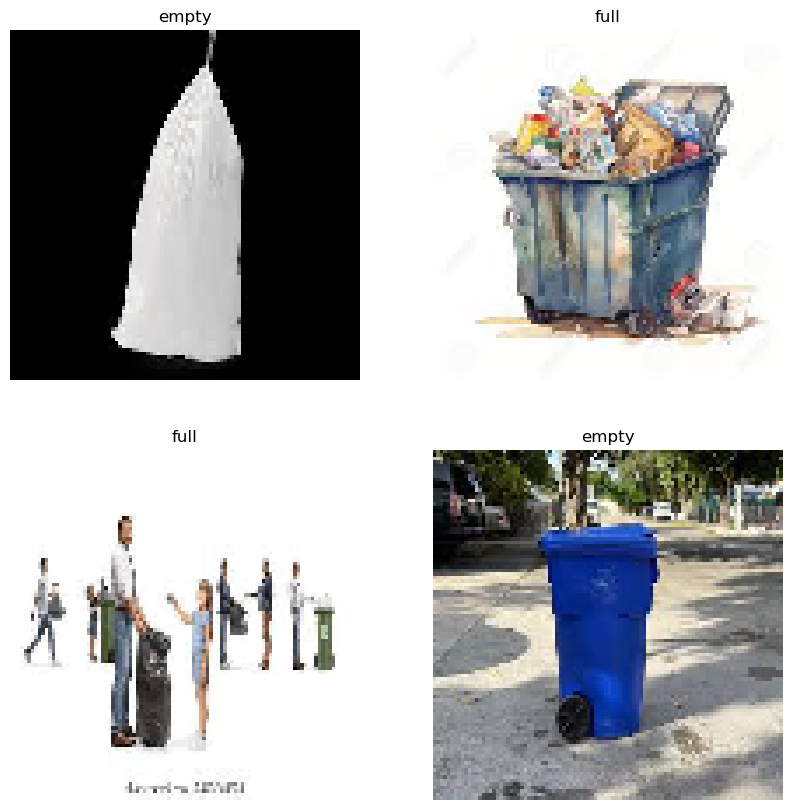

In [48]:
# affichage de quelques exemples des images aprés traitement
plt.figure(figsize=(10,10))

for i in range(4):
    idx = np.random.randint(0, len(train_data)-1)
    plt.subplot(2,2 ,i+1 )
    img_path = train_data.iloc[idx]["filename"]
    label = train_data.iloc[idx]["label"]
    image = load_img(img_path, target_size=(100,100))
    plt.title(label)
    plt.axis("off")
    plt.imshow(image)
plt.show()

In [13]:
# modèle alternatif
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
#
# model = Sequential()
#
# model.add(Input(shape=(IMG_W, IMG_H, 3)))
# # Couches de Convolution
# model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
#
# model.add(Conv2D(64, kernel_size=(3,3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
#
# model.add(Conv2D(32, kernel_size=(3,3), padding='same', activation='relu'))
# model.add(MaxPooling2D(pool_size=2))
#
# # Classification layers
# model.add(Flatten())
#
# model.add(Dense(64, activation='relu'))
# model.add(Dropout(0.2))
# model.add(Dense(32, activation='relu'))
#
# model.add(Dropout(0.2))
# model.add(Dense(1, activation='softmax'))
#
# model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
# model.summary()


In [14]:
# création du modèle
os.environ['TF_ENABLE_ONEDNN_OPTS'] = '1'

model = Sequential()

model.add(Input(shape=(IMG_W, IMG_H, 3)))

# Convolutional Layer 1
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 2
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# Convolutional Layer 3
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))

# # Convolutional Layer 4
# model.add(Conv2D(256, (3, 3), activation='relu'))
# model.add(MaxPooling2D((2, 2)))

# Flatten the output
model.add(Flatten())

# Fully Connected Layer
model.add(Dense(128, activation='relu'))

# Output Layer
model.add(Dense(1, activation='sigmoid'))  # Sigmoid for binary classification
model.compile(optimizer='adam',
              loss='binary_crossentropy',  # For binary classification
              metrics=['accuracy'])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │    11,075,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 11,169,089 (42.61 MB)

 Trainable params: 11,169,089 (42.61 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
# Entrainement du modèle

early_stopping = tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5, restore_best_weights=True)

model.fit(
    train,
    validation_data=val,
    epochs=20,
    callbacks=[early_stopping],
    # steps_per_epoch=len(train_data)//32   # le "nombre de pas par épochs": dés fois le définir est nécessaire pour prédéterminer le nombre d'épochs durant l'entrainement
)

/home/user/anaconda3/envs/tf/lib/python3.11/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 113s 2s/step - accuracy: 0.5379 - loss: 0.7914 - val_accuracy: 0.5818 - val_loss: 0.6683
Epoch 2/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 138s 2s/step - accuracy: 0.6052 - loss: 0.6638 - val_accuracy: 0.6233 - val_loss: 0.6536
Epoch 3/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.5492 - loss: 0.6776 - val_accuracy: 0.6025 - val_loss: 0.6913
Epoch 4/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 135s 2s/step - accuracy: 0.6170 - loss: 0.6599 - val_accuracy: 0.6290 - val_loss: 0.6474
Epoch 5/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 145s 2s/step - accuracy: 0.6326 - loss: 0.6500 - val_accuracy: 0.5956 - val_loss: 0.6976
Epoch 6/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 126s 2s/step - accuracy: 0.6170 - loss: 0.6590 - val_accuracy: 0.6498 - val_loss: 0.6559
Epoch 7/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 154s 3s/step - accuracy: 0.6294 - loss: 0.6460 - val_accuracy: 0.6429 - val_loss: 0.6423
Epoch 8/20
59/59 ━━━━━━━━━━━━━━━━━━━━ 124s 2s/step - accuracy: 0.6450 - loss: 0.6376 - val_accuracy: 0.6060 - v

temps d'execution = 6m 17s

In [16]:
# récupération de l'objet "history" pour pouvoir évaluer les performances durant l'entrainement
history = model.history
history.history['accuracy']

[0.5379236340522766,
 0.6051640510559082,
 0.5492200255393982,
 0.6169983744621277,
 0.6325981616973877,
 0.6169983744621277,
 0.6293706297874451,
 0.6449704170227051,
 0.6476600170135498,
 0.6438945531845093,
 0.6498117446899414,
 0.6428187489509583,
 0.6525013446807861,
 0.6503496766090393,
 0.6557288765907288,
 0.6498117446899414,
 0.6632598042488098,
 0.6584184765815735,
 0.6600322723388672,
 0.6815491914749146]

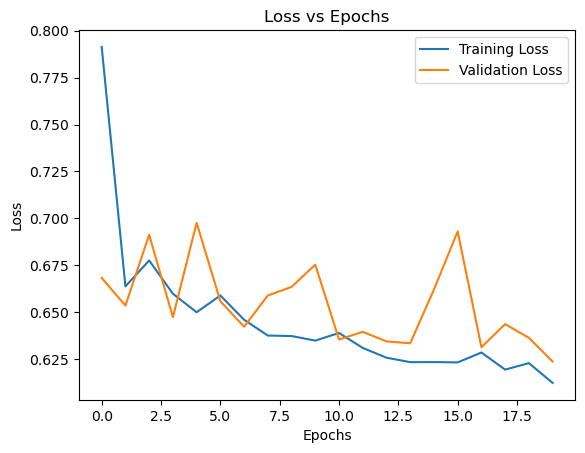

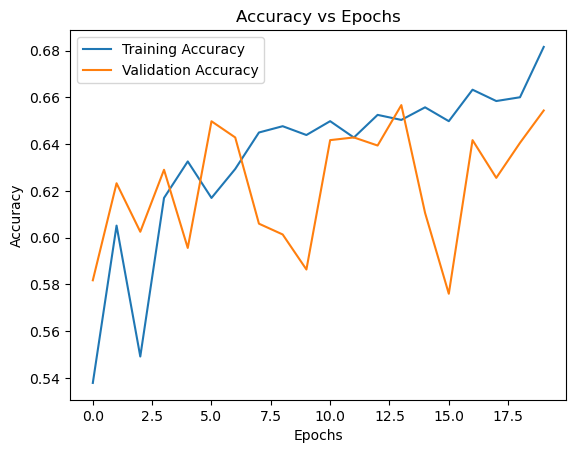

In [17]:
# Evaluation du modele
# Plotting loss
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plotting accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

142
data/empty/image_1530.jpeg
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
[[0.7851112]]
Le model a prédit:  full


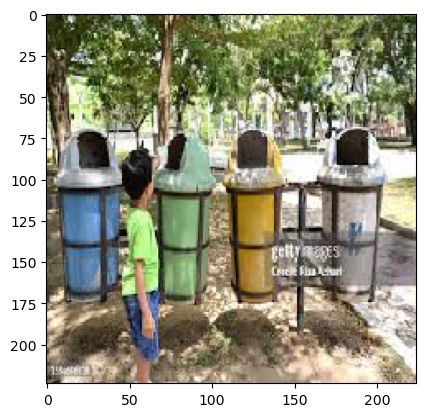

In [64]:
# Prédiction avec le modèle

# choisir une image aléatoirement sur les données test
idx = np.random.randint(0, len(test_data) - 1)
print(idx)
im_path = test_data.iloc[idx]["filename"]
print(im_path)
image= load_img(im_path, target_size= (IMG_W, IMG_H))

# préparation de l'image
image_array = img_to_array(image)/255.
image_array = image_array.reshape(1, IMG_W, IMG_H, 3)
y_pred = model.predict(image_array)

print(y_pred)

# if y_pred[0][0] >=0.5 :
if y_pred[0][0] >=0.6 : # >=0.6 pour prendre en compte une marge d'erreur sur les donnees
    name_pred = classes[1]

else:
    name_pred = classes[0]

print("Le model a prédit: ", name_pred)

# affichage de l'image utilisée pour la prédiction pour faire une vérification visuelle
plt.imshow(image)
plt.show()

In [19]:
# sauvegarde du modèle
model.save('modelv2.keras')

À noter que les prédictions du modèle comportent une marge d'erreur (même si pas large) qui est non négligeable.
Cette marge d'erreur peut être remédiée avec une quantité de données un peu plus importante et une meilleure labellisation (manuelle) des données.